# Supervised Learning - Class 7

## From Decision Trees to Random Forests and others Ensemble Methods

### Agenda
1. Introduction to Decision Trees
2. Example of diabetes prediction with Decision Trees
    - Gini impurity
    - Depth, leaves, overfitting
3. Random Forests
4. Other Ensemble methods

## 0. Import packages

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

np.random.seed(0)

## 1. Example with Decision Tree 

Generating synthetic data for illustration

In [5]:
# Generate integer synthetic data
SBP = np.random.randint(80, 160, 100)  # Systolic Blood Pressure in mmHg
TCL = np.random.randint(100, 300, 100)  # Total Cholesterol Level in mg/dL

# Combine the features into a single array
X = np.column_stack((SBP, TCL))

# Generate binary labels based on a threshold condition
y = (SBP + TCL > 300).astype(int)

Plotting the data points pairs (Systolic Blood Pressure --- Total Cholesterol Level)

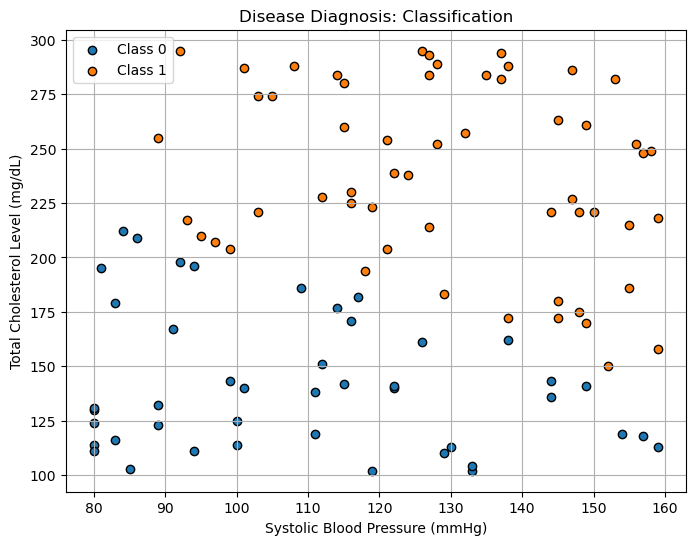

In [7]:
# Plot the synthetic data points
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(X[y == label][:, 0], X[y == label][:, 1], label=f'Class {label}', edgecolor='k')

plt.title('Disease Diagnosis: Classification')
plt.xlabel('Systolic Blood Pressure (mmHg)')
plt.ylabel('Total Cholesterol Level (mg/dL)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Train a decision tree classifier
dt_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_classifier.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=42)

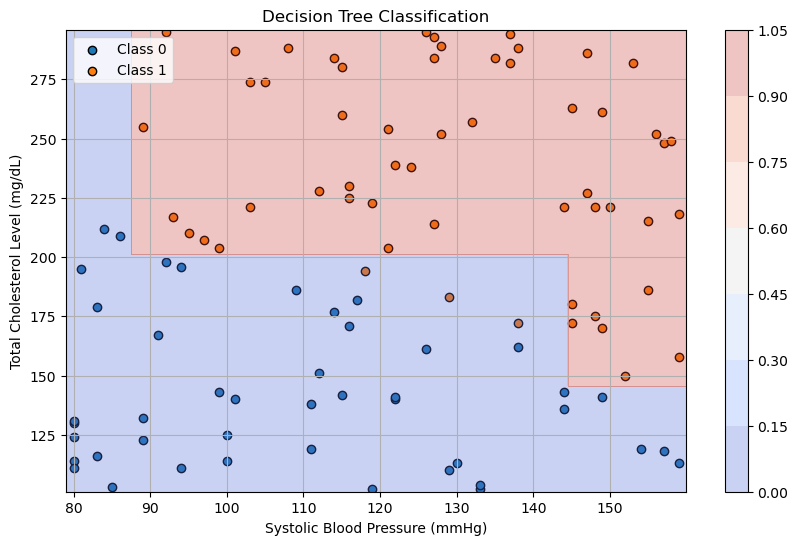

In [10]:
# Plotting the data points
plt.figure(figsize=(10, 6))
for label in np.unique(y):
    plt.scatter(X[y == label][:, 0], X[y == label][:, 1], label=f'Class {label}', edgecolor='k')

# Decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = dt_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.colorbar()

plt.title('Decision Tree Classification')
plt.xlabel('Systolic Blood Pressure (mmHg)')
plt.ylabel('Total Cholesterol Level (mg/dL)')
plt.legend()
plt.grid(True)
plt.show()

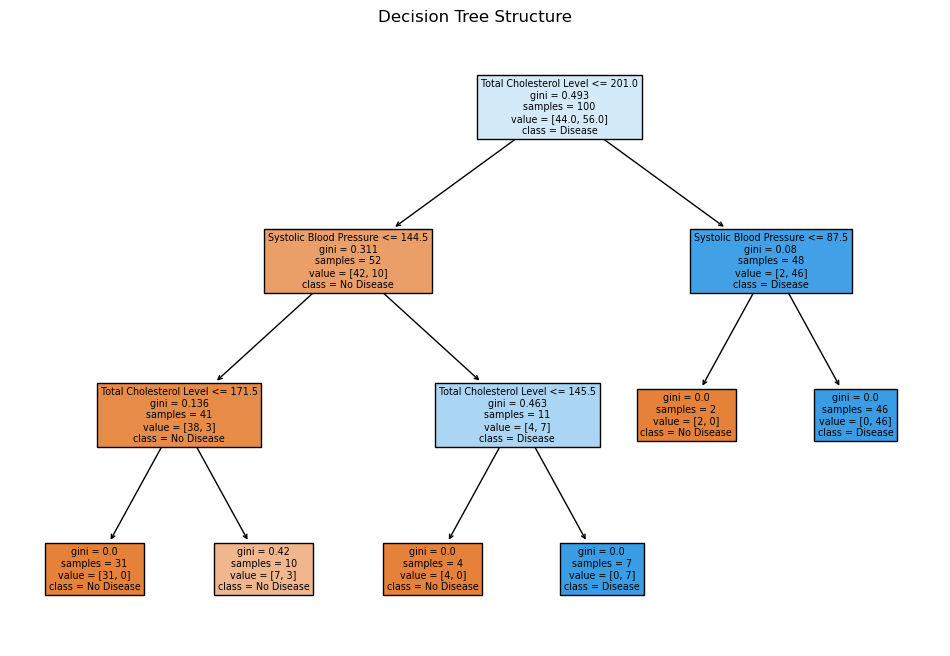

In [11]:
# Visualizing the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_classifier, feature_names=['Systolic Blood Pressure', 'Total Cholesterol Level'], class_names=['No Disease', 'Disease'], filled=True)
plt.title('Decision Tree Structure')
plt.show()

## 2. Decision Trees

Decision trees are a type of supervised learning algorithm used for both classification and regression tasks. 

They work by splitting the data into subsets based on the value of input features, creating a tree-like model of decisions. 

Each internal node of the tree represents a feature, each branch represents a decision rule, and each leaf node represents an outcome (class label or regression value).

### Attributes of Decision Trees

1. **Root Node**: The topmost node in a decision tree. It represents the entire dataset and is split into two or more homogeneous sets.
2. **Decision Nodes**: Nodes that represent a decision to be made on a specific attribute, leading to further branching.
3. **Leaf Nodes**: Terminal nodes that provide the final classification or prediction.
4. **Branches**: Edges connecting the nodes, representing the outcome of a decision at each node.

### Splitting Criteria

The process of splitting the nodes involves selecting the best attribute that partitions the data into the most homogeneous subsets. The criteria for selecting the best split include:

- **Gini Impurity**: Measures the likelihood of an incorrect classification of a randomly chosen element if it were randomly labeled according to the distribution of labels in the subset.
  
The Gini impurity is calculated as:

$$\text{Gini} = 1 - \sum_{i=1}^{n} (p_i)^2$$

where $p_i$ is the probability of an element being classified into a particular class. 

A Gini impurity of 0 indicates perfect classification, while a value close to 0.5 indicates a random distribution of elements among classes.

- **Information Gain**: Measures the reduction in entropy (uncertainty) before and after a split.
- **Chi-Square**: Statistical significance test for independence between feature and class.

### Gini Impurity Example

Consider a node containing a mix of elements from two classes, $A$ and $B$. If 70% of elements are from class $A$ and 30% from class $B$, the Gini impurity is:

$$\text{Gini} = 1 - (0.7^2 + 0.3^2) = 1 - (0.49 + 0.09) = 1 - 0.58 = 0.42$$

A split that results in purer child nodes (nodes with elements mostly from one class) is preferred, as it reduces the Gini impurity.


**Decision trees in practice...**

![](https://miro.medium.com/v2/resize:fit:1394/1*6-ctYxKmTS8v0RzwLILfXA.png)

### Use-case with the PIMA diabetes classification

#### Load the data

In [1]:
#data = pd.read_csv('')

NameError: name 'pd' is not defined